# Задача нечеткой кластеризации: Метод декомпозиционного дерева

## Preliminaries

In [131]:
import numpy as np
from typing import Callable
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', context='notebook', palette=tuple(colors), 
        rc={'axes.labelsize': 16})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


Определим Расстояние Хемминга:

In [103]:
def Hamming(i:np.int, j:np.int, table: np.ndarray) -> np.ndarray:
    """
    Computes relative Hamming distance between A_i and A_j
    Where A_i \in [0,1]^n -- n-dim. vector that contains estimation that
    i-th element has P_k feature
    """
    A_i = table[i,:] # table[:,i]
    A_j = table[j,:] # table[:,j]
    return sum(abs(A_i - A_j)) / A_i.shape[0]

Определим (max-min)-композицию:

In [104]:
def mu(ix: np.int, iy: np.int, arr1: np.ndarray, arr2=np.nan) -> np.float:
    """
    Returns (max-min)-composition for single pair
    """
    if arr2 is np.nan:
        arr2 = arr
    xz = arr1[ix,:]
    zy = arr2[:,iy]
    choose = np.array(list(map(lambda x: min(x), list(zip(xz,zy)))))
    val = max(choose)
    return val

def maxmin(arr1:np.ndarray, arr2=np.nan) -> np.ndarray:
    """
    Returns (max-min)-composition for given matrices
    """
    if arr2 is np.nan:
        arr2 = arr1
    x = arr1.shape[0]
    y = arr2.shape[1]
    pot = np.empty((x,y))
    for ix in range(0,x):
        for iy in range(0, y):
            pot[ix,iy] = mu(ix,iy,arr1,arr2)
    return pot

Определим (max-T)-композицию:

In [105]:
def T(x:np.float, y:np.float, a=-5, b=0.2) -> np.float:  
    """
    Computes given T-norm
    """
    numer = x*y - (1-a)*(1-b)*(1-x)*(1-y)
    denom = 1 + a*b*(1-x)*(1-y)
    return max(0, numer/denom)

def muT(ix: np.int, iy: np.int, arr1: np.ndarray, arr2=np.nan) -> np.float:
    """
    Returns (max-T)-composition for single pair
    """
    if arr2 is np.nan:
        arr2 = arr
    xz = arr1[ix,:]
    zy = arr2[:,iy]
    choose = np.array(list(map(lambda x: T(*x), list(zip(xz,zy)))))
    val = max(choose)
    return val

def maxT(arr1:np.ndarray, arr2=np.nan, T=T) -> np.ndarray:
    """
    Computes (max-T)-composition for given matrices and given T-norm
    """
    if arr2 is np.nan:
        arr2 = arr1
    x = arr1.shape[0]
    y = arr2.shape[1]
    pot = np.empty((x,y))
    for ix in range(0,x):
        for iy in range(0, y):
            pot[ix,iy] = np.round(muT(ix,iy,arr1,arr2),2)
    return pot

Определим транзитивное замыкание:

In [106]:
def union(arr1:np.ndarray, arr2:np.ndarray) -> np.ndarray:
    """
    Computes union of 2 fuzzy relations
    """
    shape = arr1.shape
    pot = np.empty(shape)
    for ix in range(0,shape[0]):
        for iy in range(0,shape[1]):
            pot[ix,iy] = max(arr1[ix,iy],arr2[ix,iy])
    return pot

def trans_closure(arr:np.ndarray, comp = maxmin, show = False) -> np.ndarray:
    """
    Computes transitive closure of a fuzzy relation
    """
    pot = arr
    new_arr = comp(arr)
    count = 1
    if show:
        print(count)
        print(new_arr)
        print('----------')
    if (new_arr==arr).all():
        return pot
    else:
        pot = union(new_arr,arr)
        while True:
            prev_arr = new_arr
            new_arr = comp(new_arr,arr)
            count += 1
            if show:
                print(count)
                print(new_arr)
                print('----------')
            if (prev_arr==new_arr).all():
                return pot
            else:
                pot = union(new_arr,arr)
                
def transitive(arr: np.ndarray, comp = maxmin) -> bool:
    """
    Checks whether given matrix is transitive or not
    """
    arr_squared = comp(arr)
    return (arr_squared <= arr).all()

Определим процедуру декомпозиции отношения эквивалентности:

In [107]:
def alphas(arr:np.ndarray) -> np.ndarray:
    """
    Returns valid alpha for future alpha-decomposition for decomposing tree
    """
    mask = (arr > 0) & (arr < 1)
    alphs = np.unique(np.append(arr[mask], [1])) # add 1 separately in case if r>1 ∀r ∈ R
    return alphs 

def decompose(arr:np.ndarray) -> np.ndarray:
    """
    Returns pairs (alpha, R_aplha) that are given during decomposition for given relation
    Such that for given R: R = max_alpha{alpha * R_aplha}, where alpha \in (0,1]
    """
    alphs = alphas(arr)
    cuts = []
    for a in alphs:
        mask = (arr >= a)
        cuts.append(mask.astype(np.int))
    return list(zip(alphs,cuts))

Определим процедуру группировки строк в матрице, чтобы определить классы эквивалентности:

In [108]:
def equiv_class(arr: np.ndarray, U: list) -> np.ndarray:
    """
    Determine equivalence classes by grouping rows in a matrix
    Such that if arr[i:] = arr[j:], then U[i] ~ U[j]
    """ 
    
    # get uniq rows with counts
    unq, count = np.unique(arr, axis=0, return_counts=True)
    repeated_groups = unq[count > 1]  # choose rows with counts > 1
    
    classes = []
    unlisted = np.linspace(0,arr.shape[0]-1,arr.shape[0]).astype('int64')
    for repeated_group in repeated_groups:
        # get idx for repeated rows
        repeated_idx = np.argwhere(np.all(arr == repeated_group, axis=1))
        unlisted = [e for e in unlisted if e not in repeated_idx.ravel()]
        # add them to list of equiv classes
        classes.append([U[i] for i in repeated_idx.ravel()])
    # find elements of U which are not in classes
    # so it is the elements which are single in its equiv class
    for i in unlisted:
        classes.append([U[i]])  # add them to classes
    return classes

Определим функцию построения декомпозиционного дерева:

In [109]:
def find_prev(name:str, prev:list) -> list:
    """
    Find several ancestors for given node
    """
    name_prop = name[:name.index('.')-2]
    for prev_name in prev: 
        prev_name_prop = prev_name[:prev_name.index('.')-2]
        if set(name_prop).issubset(set(prev_name_prop)):
            return [prev_name]
        
    res = []
    for prev_name in prev: 
        prev_name_prop = prev_name[:prev_name.index('.')-2]
        if set(prev_name_prop).issubset(set(name_prop)):
            res.append(prev_name)
    return res

def tree(arr: list) -> nx.DiGraph:
    """
    Returns networkx.DiGraph instance -- decomposing tree -- based on given set of alpha-cuts
    Even alpha-cut is an equivalence relation, thus every cut can be factorized
    """
    #get factor sets
    factor_arr = [ equiv_class(arr[i][1], Obj) for i in range(len(arr))]
    
    G = nx.DiGraph()
    prev = []  # labels of nodes from previous level
    for f in range(len(factor_arr)):  # for every factor set
        curr = []  # labels of nodes from current level
        for eq_class in factor_arr[f]:  # for every equivalence class
            name = " ".join(eq_class)  # create label for a node 
            name += " ({:.3f})".format(arr[f][0])  # with alpha-value
            curr.append(name)
            G.add_node(name)
            #prev_node = False  # prev node is not found atm
            #----
            prevs = find_prev(name, prev)
            for prev_name in prevs:
                G.add_edge(prev_name,name)
            
        prev = curr
    
    return G

Определим функцию, которая рисует декомпозиционное дерево:

In [110]:
def treeplot(G:nx.DiGraph, title: str, shape = (15,15)):
    """
    Plot given networkx.Graph
    """
    plt.figure(figsize=shape)   
    plt.title(title)
    pos=graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=1500, node_shape = 's')
    plt.savefig(title + ".jpg")
    plt.show()

## Main Part

Имеется следующая таблица:

In [111]:
U = ('a', 'b', 'c', 'd', 'e')
Obj = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
given = "0.8 0.7 0.7 0.3 0.0 | 0.5 1 0.5 0.0 0.0 | 0.5 0.6 0.8 0.4 0.2 | \
         0.9 0.5 0.3 0.2 0.2 | 0.6 0.8 0.9 0.3 0.1 | 0.2 0.4 0.6 0.8 0.9"
lines = given.split("|")
elements = [line.split() for line in lines]
table = np.array([list(map(lambda x: float(x), line)) for line in elements])
table

array([[0.8, 0.7, 0.7, 0.3, 0. ],
       [0.5, 1. , 0.5, 0. , 0. ],
       [0.5, 0.6, 0.8, 0.4, 0.2],
       [0.9, 0.5, 0.3, 0.2, 0.2],
       [0.6, 0.8, 0.9, 0.3, 0.1],
       [0.2, 0.4, 0.6, 0.8, 0.9]])

С помощью расстояния Хемминга построим матрицу отношения несходства $R$, а после перейдем к матрице сходства:

In [112]:
card = table.shape[0]  # 1 is for {a,b,c,d,e}
R = np.empty((card,card))
for i in range(0,card):
    for j in range(0,card):
        R[i,j] = Hamming(i,j,table)
#R = normalize(R)
Rhat = 1 - R
print("R matrix:\n{}\n\nRhat matrix:\n{}".format(R,Rhat))

R matrix:
[[0.   0.22 0.16 0.2  0.12 0.48]
 [0.22 0.   0.26 0.3  0.22 0.54]
 [0.16 0.26 0.   0.24 0.12 0.36]
 [0.2  0.3  0.24 0.   0.28 0.48]
 [0.12 0.22 0.12 0.28 0.   0.48]
 [0.48 0.54 0.36 0.48 0.48 0.  ]]

Rhat matrix:
[[1.   0.78 0.84 0.8  0.88 0.52]
 [0.78 1.   0.74 0.7  0.78 0.46]
 [0.84 0.74 1.   0.76 0.88 0.64]
 [0.8  0.7  0.76 1.   0.72 0.52]
 [0.88 0.78 0.88 0.72 1.   0.52]
 [0.52 0.46 0.64 0.52 0.52 1.  ]]


Найдем транзитивное замыкание $\hat{R}$ с двумя разными композициями:

In [113]:
ClR = trans_closure(Rhat)
TClR = trans_closure(Rhat, comp=maxT)
print('Transitive closure with (max-min)-composition:\n{}\n \
Transitive closure with (max-T)-composition:\n{}'.format(ClR, TClR))

Transitive closure with (max-min)-composition:
[[1.   0.78 0.88 0.8  0.88 0.64]
 [0.78 1.   0.78 0.78 0.78 0.64]
 [0.88 0.78 1.   0.8  0.88 0.64]
 [0.8  0.78 0.8  1.   0.8  0.64]
 [0.88 0.78 0.88 0.8  1.   0.64]
 [0.64 0.64 0.64 0.64 0.64 1.  ]]
 Transitive closure with (max-T)-composition:
[[1.   0.78 0.84 0.8  0.88 0.52]
 [0.78 1.   0.74 0.7  0.78 0.46]
 [0.84 0.74 1.   0.76 0.88 0.64]
 [0.8  0.7  0.76 1.   0.72 0.52]
 [0.88 0.78 0.88 0.72 1.   0.52]
 [0.52 0.46 0.64 0.52 0.52 1.  ]]


Убедимся в транзитивности:

In [114]:
print('Transitive closure with (max-min)-composition is transitive') if transitive(ClR) \
else print('Transitive closure with (max-min)-composition is not transitive')
print('Transitive closure with (max-T)-composition is transitive') if transitive(TClR, 
                                                                                 comp=maxT) \
else print('Transitive closure with (max-T)-composition is not transitive')

Transitive closure with (max-min)-composition is transitive
Transitive closure with (max-T)-composition is transitive


#### Построим декомпозиционное дерево для (max-min)-композиции
Разложим полученное с помощью (max-min)-композиции отношение по теореме о декомпозиции через систему $\alpha$-срезов:

In [115]:
decClR = decompose(ClR)
for alpha, cut in decClR:
    print("For \\alpha = {:.3f} there is a cut:\n{}\n".format(alpha,cut))

For \alpha = 0.640 there is a cut:
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]

For \alpha = 0.780 there is a cut:
[[1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [0 0 0 0 0 1]]

For \alpha = 0.800 there is a cut:
[[1 0 1 1 1 0]
 [0 1 0 0 0 0]
 [1 0 1 1 1 0]
 [1 0 1 1 1 0]
 [1 0 1 1 1 0]
 [0 0 0 0 0 1]]

For \alpha = 0.880 there is a cut:
[[1 0 1 0 1 0]
 [0 1 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 1 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 1]]

For \alpha = 1.000 there is a cut:
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]



Каждый полученный $\alpha$-срез -- отношение эквивалентности на универсальном множестве $U$, тогда построим фактор-множества:

In [116]:
factor_decClR = [ equiv_class(decClR[i][1], Obj) for i in range(len(decClR))]
'''
for i in range(len(decClR)):
    print("For \\alpha = {:.3f} there is a factor set:\n{}\n".\
          format(decClR[i][0],factor_decClR[i]))
'''
factor_decClR

[[['A1', 'A2', 'A3', 'A4', 'A5', 'A6']],
 [['A1', 'A2', 'A3', 'A4', 'A5'], ['A6']],
 [['A1', 'A3', 'A4', 'A5'], ['A2'], ['A6']],
 [['A1', 'A3', 'A5'], ['A2'], ['A4'], ['A6']],
 [['A1'], ['A2'], ['A3'], ['A4'], ['A5'], ['A6']]]

Построим декомпозиционное дерево по полученным фактор-множествам(фактор-множества строятся непосредственно в функции $ {\it tree}$):

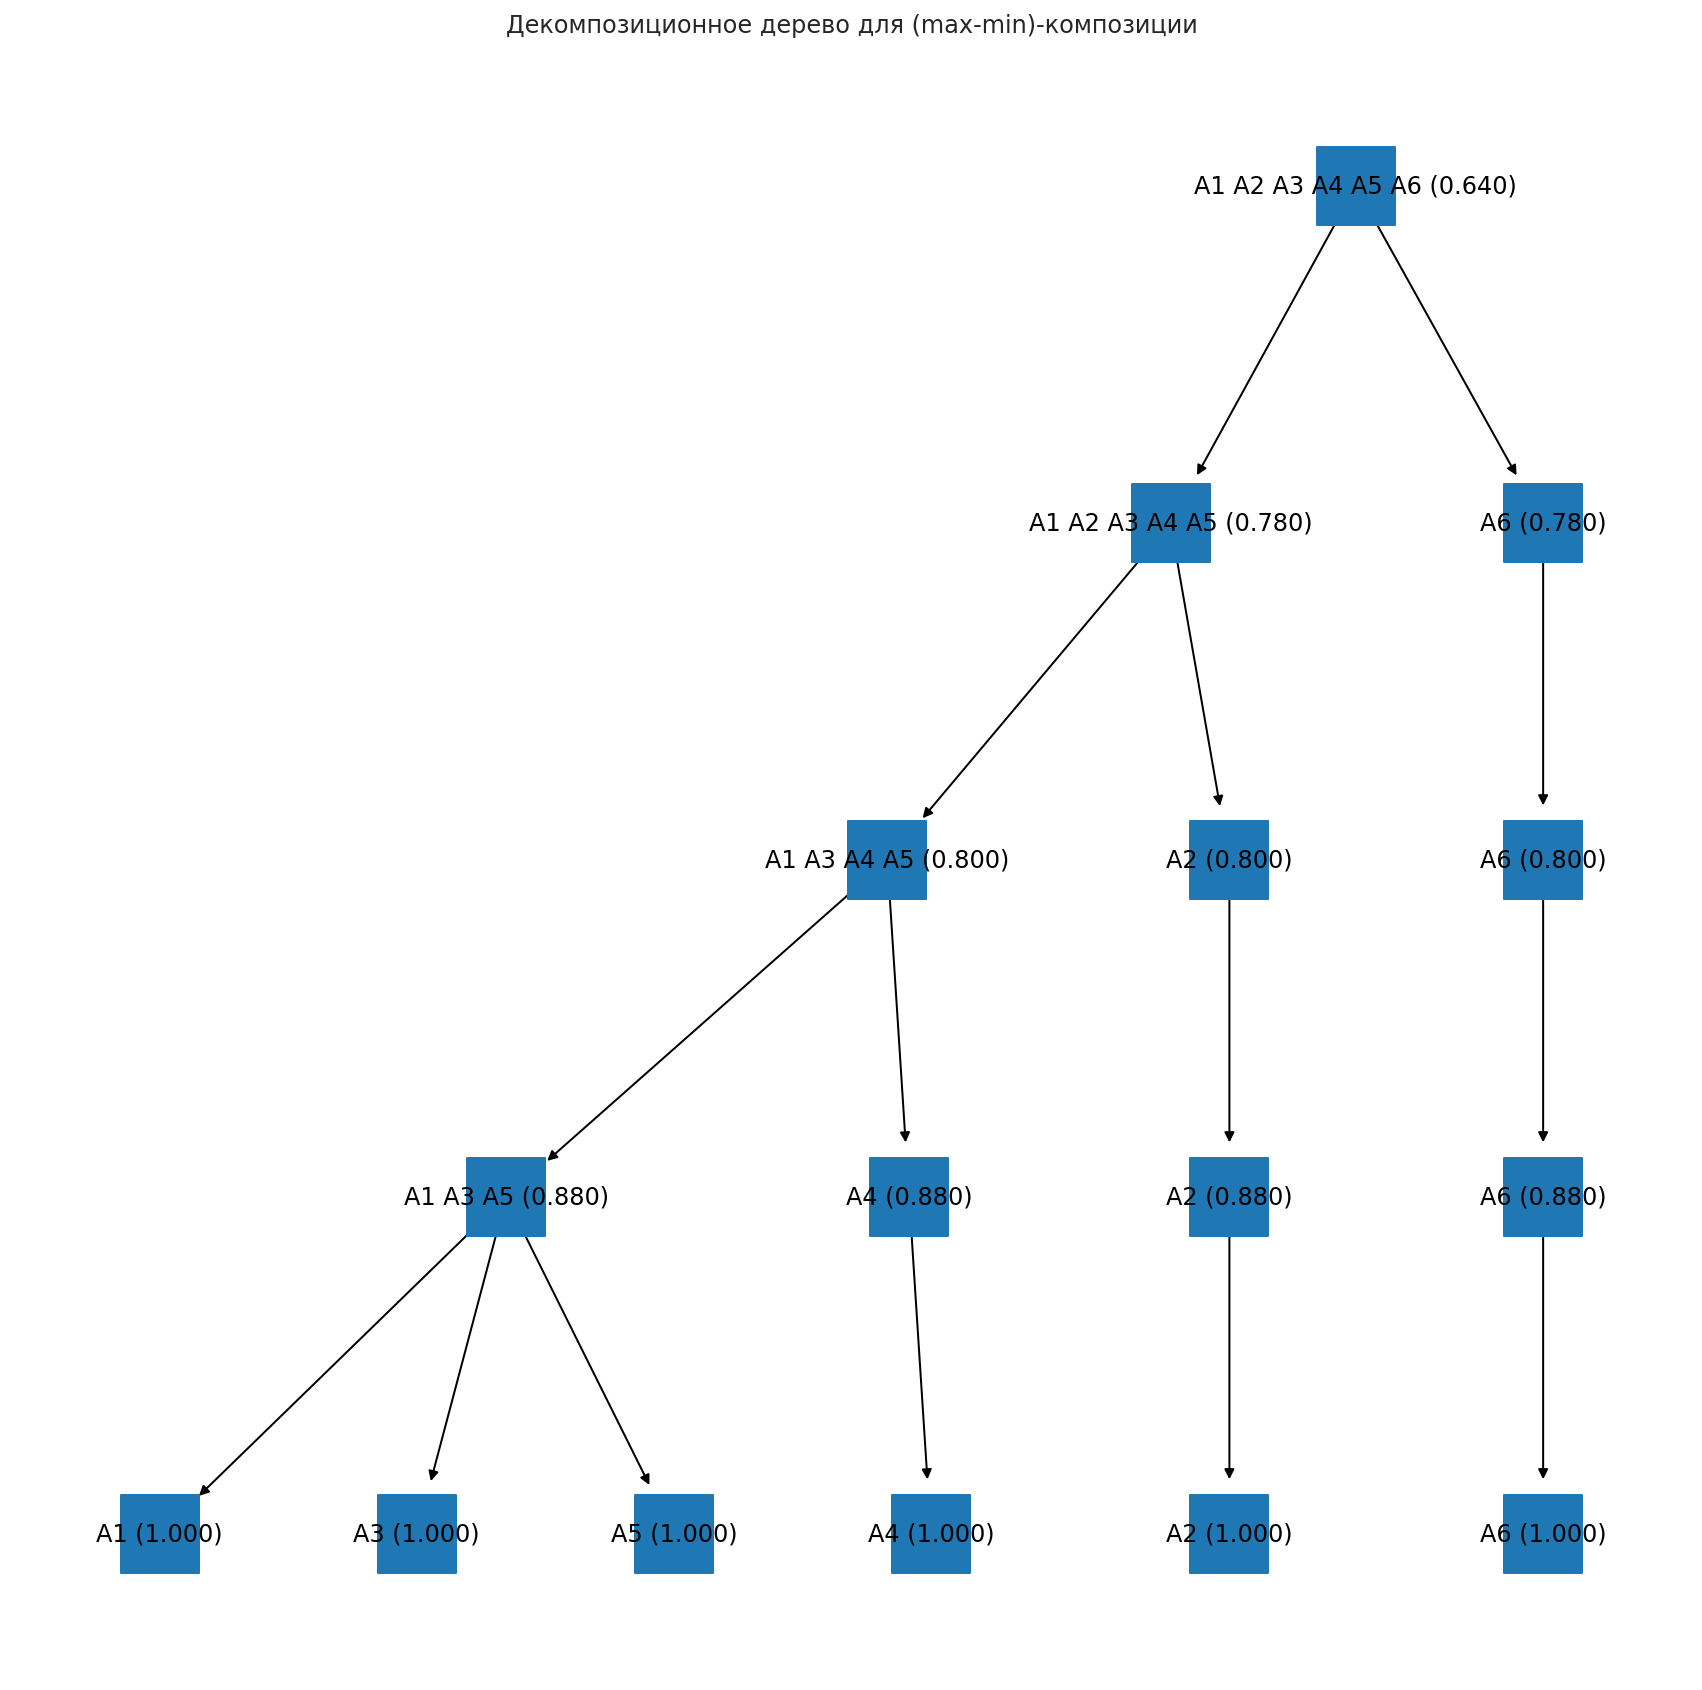

In [117]:
G_ClR = tree(decClR)
treeplot(G_ClR, title = 'Декомпозиционное дерево для (max-min)-композиции')

#### Построим декомпозиционное дерево для (max-T)-композиции
Разложим полученное с помощью (max-T)-композиции отношение по теореме о декомпозиции через систему $\alpha$-срезов:

In [118]:
decTClR = decompose(TClR)
for alpha, cut in decTClR:
    print("For \\alpha = {:.3f} there is a cut:\n{}\n".format(alpha,cut))

For \alpha = 0.460 there is a cut:
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]

For \alpha = 0.520 there is a cut:
[[1 1 1 1 1 1]
 [1 1 1 1 1 0]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 0 1 1 1 1]]

For \alpha = 0.640 there is a cut:
[[1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 1]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [0 0 1 0 0 1]]

For \alpha = 0.700 there is a cut:
[[1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 0]
 [0 0 0 0 0 1]]

For \alpha = 0.720 there is a cut:
[[1 1 1 1 1 0]
 [1 1 1 0 1 0]
 [1 1 1 1 1 0]
 [1 0 1 1 1 0]
 [1 1 1 1 1 0]
 [0 0 0 0 0 1]]

For \alpha = 0.740 there is a cut:
[[1 1 1 1 1 0]
 [1 1 1 0 1 0]
 [1 1 1 1 1 0]
 [1 0 1 1 0 0]
 [1 1 1 0 1 0]
 [0 0 0 0 0 1]]

For \alpha = 0.760 there is a cut:
[[1 1 1 1 1 0]
 [1 1 0 0 1 0]
 [1 0 1 1 1 0]
 [1 0 1 1 0 0]
 [1 1 1 0 1 0]
 [0 0 0 0 0 1]]

For \alpha = 0.780 there is a cut:
[[1 1 1 1 1 0]
 [1 1 0 0 1 0]
 [1 0 1 0 1 0]
 [1 0 0 1 0 0]
 [1 1 1 0 1 0]
 

Каждый полученный $\alpha$-срез -- отношение эквивалентности на универсальном множестве $U$, тогда построим фактор-множества:

In [124]:
factor_decTClR = [ equiv_class(decTClR[i][1], Obj) for i in range(len(decTClR))]
for i in range(len(decTClR)):
    print("For \\alpha = {:.3f} there is a factor set:\n{}\n".\
          format(decTClR[i][0],factor_decTClR[i]))

For \alpha = 0.460 there is a factor set:
[['A1', 'A2', 'A3', 'A4', 'A5', 'A6']]

For \alpha = 0.520 there is a factor set:
[['A1', 'A3', 'A4', 'A5'], ['A2'], ['A6']]

For \alpha = 0.640 there is a factor set:
[['A1', 'A2', 'A4', 'A5'], ['A3'], ['A6']]

For \alpha = 0.700 there is a factor set:
[['A1', 'A2', 'A3', 'A4', 'A5'], ['A6']]

For \alpha = 0.720 there is a factor set:
[['A1', 'A3', 'A5'], ['A2'], ['A4'], ['A6']]

For \alpha = 0.740 there is a factor set:
[['A2', 'A5'], ['A1', 'A3'], ['A4'], ['A6']]

For \alpha = 0.760 there is a factor set:
[['A1'], ['A2'], ['A3'], ['A4'], ['A5'], ['A6']]

For \alpha = 0.780 there is a factor set:
[['A1'], ['A2'], ['A3'], ['A4'], ['A5'], ['A6']]

For \alpha = 0.800 there is a factor set:
[['A3', 'A5'], ['A1'], ['A2'], ['A4'], ['A6']]

For \alpha = 0.840 there is a factor set:
[['A1', 'A3', 'A5'], ['A2'], ['A4'], ['A6']]

For \alpha = 0.880 there is a factor set:
[['A1'], ['A2'], ['A3'], ['A4'], ['A5'], ['A6']]

For \alpha = 1.000 there is a fa

Построим декомпозиционное дерево по полученным фактор-множествам(фактор-множества строятся непосредственно в функции $ {\it tree}$):

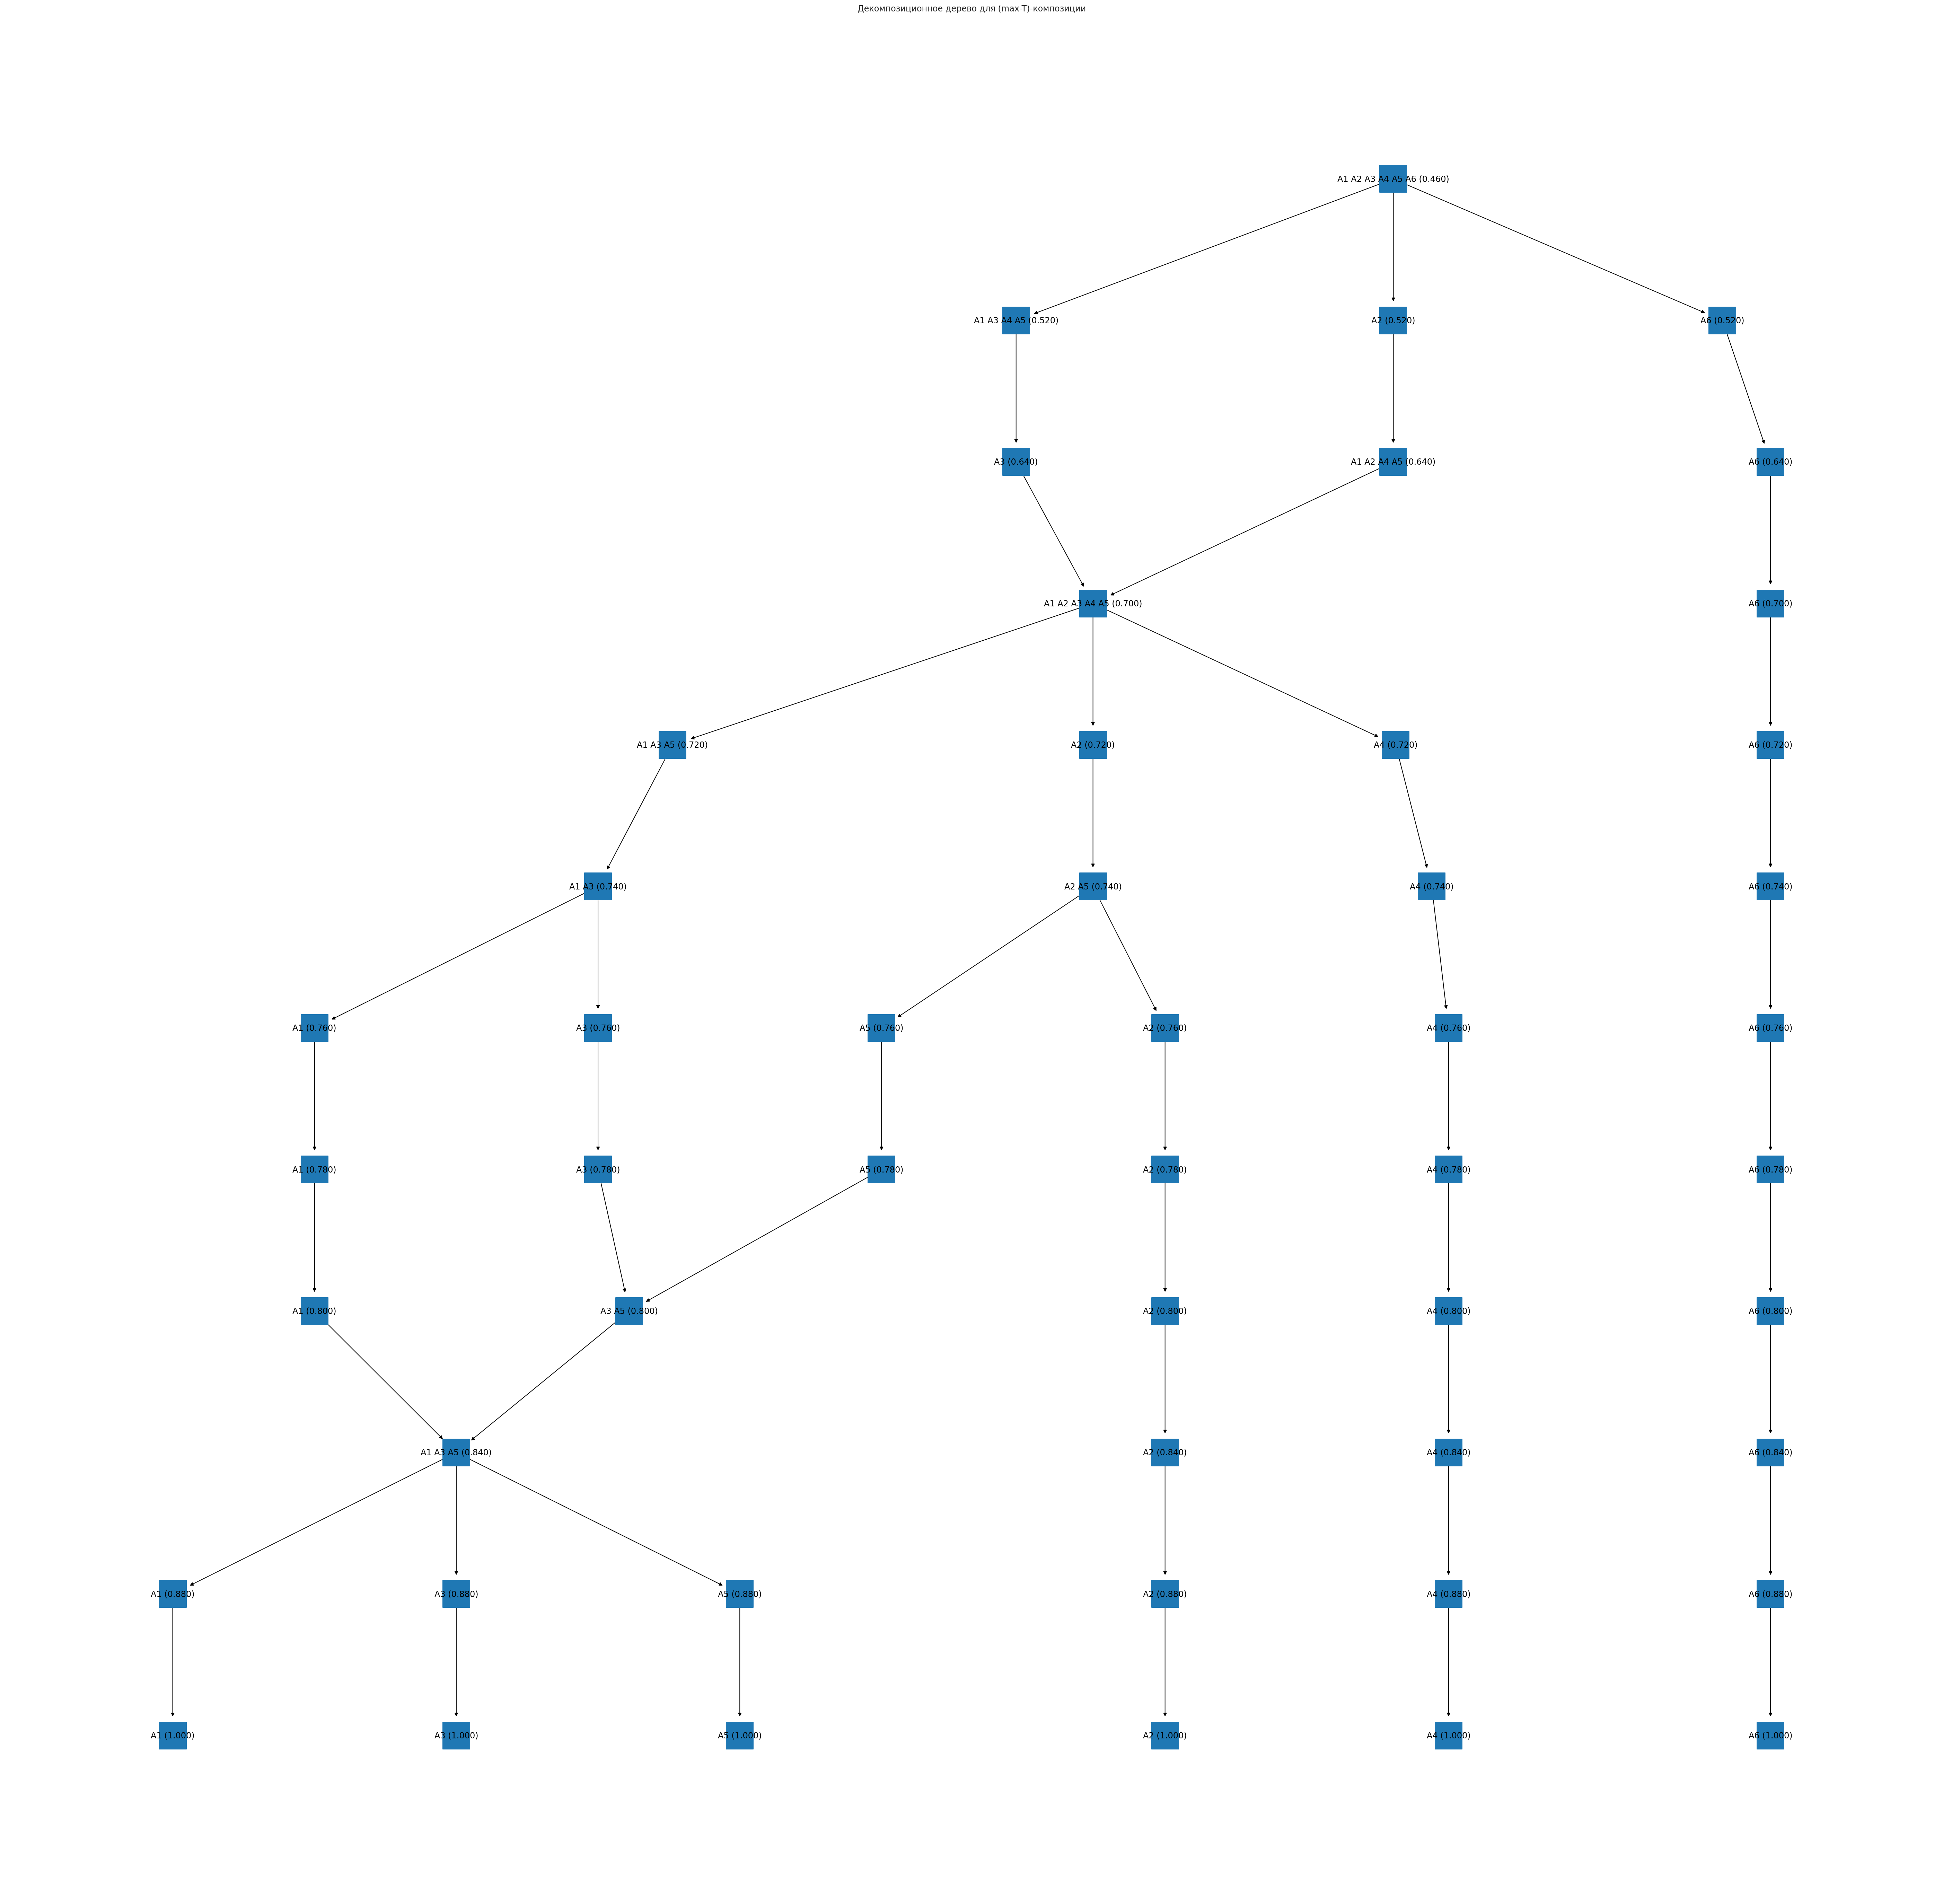

In [120]:
G_TClR = tree(decTClR)
treeplot(G_TClR, title = 'Декомпозиционное дерево для (max-T)-композиции', shape = (50,50))

#### Заполним таблицу со значениями:

||Анализ|(max-min)|(max-T)|
|------|------|------|------|
|1|Укажите значение $\alpha$, когда впервые появился тривиальный класс|0.78|0.42|
|2|Укажите значение $\alpha$, когда появилось тривиальное разбиение|0.88|0.740|
|3|Сколько имеется зон неустойчивой классификации|0|7|
|4|Укажите зоны неустойчивой классификации в форме промежутков значений $\alpha$ |-|[0.64;0.84]|
||Укажите объекты, для которых образуется зона неустойчивой классификации|-|$\{A_1,A_2,A_3,A_4,A_5\}$|
|5|Укажите зону роста в форме промежутка для $\alpha$|[0.64; 1]|[0.46;0.88]|
|6|Для каждого объекта $A_i$ укажите значение $\alpha$, когда данный объект впервые образует тривиальный класс |$A_1$:1 <br> $A_2$:0.8 <br> $A_3$:1 <br> $A_4$:0.88 <br> $A_5$:1 <br> $A_6$:0.78|$A_1$:0.76 <br> $A_2$:0.52 <br> $A_3$:0.64 <br> $A_4$:0.72 <br> $A_5$:0.76 <br> $A_6$:0.52|
|7|Для каждого объекта $A_i$ укажите значение $\alpha$, при котором данный объект входит в класс максимальной мощности|$A_1$:0.78 <br> $A_2$:0.78 <br> $A_3$:0.78 <br> $A_4$:0.78 <br> $A_5$:0.78 <br> $A_6$:0.78|$A_1$:0.7 <br> $A_2$: <br> $A_3$:0.7 <br> $A_4$:0.7 <br> $A_5$:0.7 <br> $A_6$:0.52|
|8|Укажите мощность максимального класса(не принимаем во внимание первоначальный класс)|5|5|